<a href="https://colab.research.google.com/drive/1c1h4XXFEMeozgxAXE4kFrVsUuV7-Hila#scrollTo=d2IUvE_1fJiV" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Emotion Detection

## Import libraries

In [1]:
import os
import datetime
import tensorflow as tf
import shutil
import cv2
import imghdr
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
import numpy as np
from tensorflow.keras.models import load_model
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import  plotly.express as px 

## Load the data from kaggle

In [2]:
! pip install -q kaggle

In [3]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"otmanheddouch","key":"c77f8d9d542ddf10cdb0a230c627fb89"}'}

In [4]:
! mkdir ~/.kaggle

In [5]:
! cp kaggle.json ~/.kaggle/

In [6]:
!chmod 600 ~/.kaggle/kaggle.json

In [7]:
!kaggle datasets download -d deadskull7/fer2013

 98% 95.0M/96.6M [00:05<00:00, 22.7MB/s]
100% 96.6M/96.6M [00:05<00:00, 19.3MB/s]


In [8]:
! mkdir data

In [9]:
! unzip fer2013.zip -d data

Archive:  fer2013.zip
  inflating: data/fer2013.csv        


In [10]:
df = pd.read_csv("data/fer2013.csv")
df.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [11]:
df["emotion"].value_counts()

3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: emotion, dtype: int64

In [13]:
emotions = np.array(("Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"))
fig = px.bar(x=[emotions[i]for i in df["emotion"].value_counts().index],y=df["emotion"].value_counts().values,title="Data Distributon")
fig.update_xaxes(title="Emotions")
fig.update_yaxes(title="Count")

In [14]:
def reshape(pixels):
  g = []
  for i in str(pixels).split(' '):
    g.append(int(i))
  return np.array(g).reshape(48,48)

In [15]:
df["pixels_"] = df["pixels"].map(reshape)

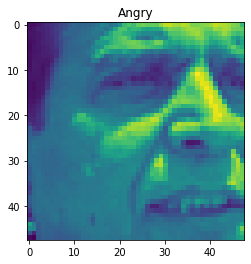

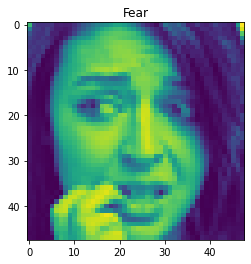

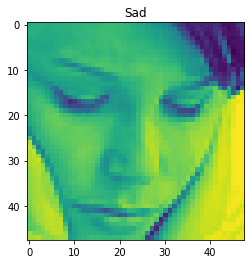

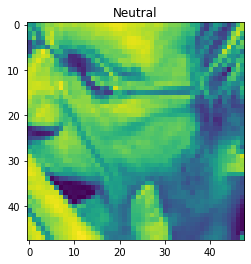

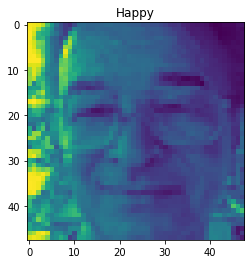

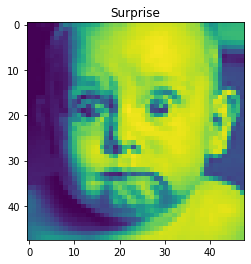

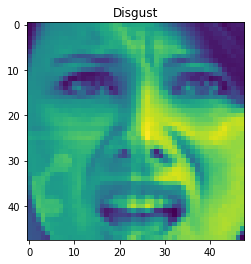

In [16]:
for class_ in df["emotion"].unique():
  plt.figure()
  plt.imshow(df.loc[df["emotion"] ==class_]["pixels_"].values[4])
  plt.title(emotions[class_])

In [17]:
main_dir = "data/"
train_dir = "data/train/"
test_dir = "data/test/"

In [18]:
if not os.path.exists("data/train/"):
  os.makedirs("data/train/")
if not os.path.exists("data/test/"):
  os.makedirs("data/test/")

if not os.path.exists("data/val/"):
  os.makedirs("data/val/")
# Create data for training
for class_ in df["emotion"].unique():
  len_training = df.loc[df["Usage"] == "Training"].loc[df["emotion"] == 0].shape[0]
  if not os.path.exists(f"{train_dir}/{emotions[class_]}"):
    os.makedirs(f"{train_dir}/{emotions[class_]}")
  for i,val in enumerate(df.loc[df["emotion"] == class_]["pixels_"].values[:len_training]):
    cv2.imwrite(f"{train_dir}/{emotions[class_]}/{class_}_{i}.jpg",val)


# Create data for testing
for class_ in df["emotion"].unique():
  len_testing = df.loc[df["Usage"] == "PrivateTest"].loc[df["emotion"] == 0].shape[0]
  if not os.path.exists(f"{test_dir}/{emotions[class_]}"):
    os.makedirs(f"{test_dir}/{emotions[class_]}")
  for i,val in enumerate(df.loc[df["emotion"] == class_]["pixels_"].values[:len_testing]):
    cv2.imwrite(f"{test_dir}/{emotions[class_]}/{class_}_{i}.jpg",val)



# Create data for validation
for class_ in df["emotion"].unique():
  len_testing = df.loc[df["Usage"] == "PublicTest"].loc[df["emotion"] == 0].shape[0]
  if not os.path.exists(f"{train_dir}/{emotions[class_]}"):
    os.makedirs(f"{train_dir}/{emotions[class_]}")
  for i,val in enumerate(df.loc[df["emotion"] == class_]["pixels_"].values[:len_testing]):
    cv2.imwrite(f"{train_dir}/{emotions[class_]}/{class_}_{i}_.jpg",val)

In [19]:
import random
def plot_random_img(dir,labels):
  label = random.choice(labels)
  img_path = dir+label+"/"+random.choice(os.listdir(dir+"/"+label+"/"))
  img = cv2.imread(img_path)
  plt.title(label)
  plt.imshow(img)

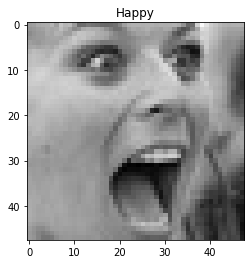

In [20]:
plot_random_img(test_dir,emotions)

In [21]:
train_data = tf.keras.utils.image_dataset_from_directory(train_dir,image_size=(48,48),label_mode="categorical")
test_data = tf.keras.utils.image_dataset_from_directory(test_dir,image_size=(48,48),label_mode="categorical")

Found 27786 files belonging to 7 classes.
Found 3437 files belonging to 7 classes.


/usr/local/lib/python3.9/dist-packages/matplotlib/text.py:1223: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



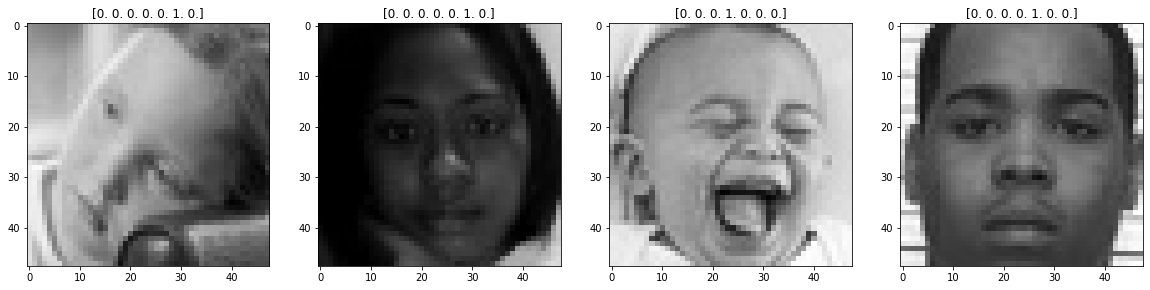

In [22]:
data_iterator = test_data.as_numpy_iterator()
batch = data_iterator.next()
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [23]:
train_data = train_data.map(lambda x,y:(x/255,y))
test_data = test_data.map(lambda x,y:(x/255,y))

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [24]:
base_model = tf.keras.applications.DenseNet169(input_shape = (48, 48, 3), # Shape of our images
include_top = False, # Leave out the last fully connected layer
weights = 'imagenet')
base_model.trainable = False
Input = tf.keras.layers.Input(shape=(48,48,3),name="input_layer")
x = base_model(Input,training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(256, activation="relu")(x)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Dense(256, activation="relu")(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(512, activation="relu")(x)
x = tf.keras.layers.Dropout(0.5) (x)
output = tf.keras.layers.Dense(7, activation="softmax", name="classification")(x)
model = tf.keras.Model(Input,output)

model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

51877672/51877672 [==============================] - 3s 0us/step


In [25]:
def create_tensorboard_callback(dir_name, experiment_name):
    log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
    print(f"Saving TensorBoard log files to: {log_dir}")
    return tensorboard_callback

In [26]:
model.fit(train_data,validation_data=test_data,epochs=20,callbacks=[create_tensorboard_callback("log_dir","model")])

Saving TensorBoard log files to: log_dir/model/20230312-192931
Epoch 1/20
869/869 [==============================] - 63s 50ms/step - loss: 1.7692 - accuracy: 0.2895 - val_loss: 1.7658 - val_accuracy: 0.3253
Epoch 2/20
869/869 [==============================] - 30s 35ms/step - loss: 1.6733 - accuracy: 0.3497 - val_loss: 1.6933 - val_accuracy: 0.3585
Epoch 3/20
869/869 [==============================] - 30s 35ms/step - loss: 1.6256 - accuracy: 0.3660 - val_loss: 1.6152 - val_accuracy: 0.3832
Epoch 4/20
869/869 [==============================] - 34s 39ms/step - loss: 1.5903 - accuracy: 0.3791 - val_loss: 1.5632 - val_accuracy: 0.4126
Epoch 5/20
869/869 [==============================] - 35s 40ms/step - loss: 1.5575 - accuracy: 0.3948 - val_loss: 1.4740 - val_accuracy: 0.4585
Epoch 6/20
869/869 [==============================] - 34s 39ms/step - loss: 1.5212 - accuracy: 0.4127 - val_loss: 1.4487 - val_accuracy: 0.4661
Epoch 7/20
869/869 [==============================] - 30s 35ms/step - los

In [27]:
model.save("model.h5")

In [29]:
base_model.trainable = True

for layer in base_model.layers[:-5]:
  layer.trainable = False

model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=["accuracy"])

In [31]:
model.fit(train_data,validation_data=test_data,epochs=20,callbacks=[create_tensorboard_callback("log_dir","model_after_fin")])

Saving TensorBoard log files to: log_dir/model_after_fin/20230312-194255
Epoch 1/20
869/869 [==============================] - 50s 43ms/step - loss: 1.1911 - accuracy: 0.5444 - val_loss: 0.8618 - val_accuracy: 0.7096
Epoch 2/20
869/869 [==============================] - 32s 37ms/step - loss: 1.1618 - accuracy: 0.5532 - val_loss: 0.8377 - val_accuracy: 0.7169
Epoch 3/20
869/869 [==============================] - 33s 38ms/step - loss: 1.1505 - accuracy: 0.5597 - val_loss: 0.8161 - val_accuracy: 0.7256
Epoch 4/20
869/869 [==============================] - 30s 35ms/step - loss: 1.1330 - accuracy: 0.5639 - val_loss: 0.8013 - val_accuracy: 0.7297
Epoch 5/20
869/869 [==============================] - 33s 38ms/step - loss: 1.1265 - accuracy: 0.5647 - val_loss: 0.8021 - val_accuracy: 0.7344
Epoch 6/20
869/869 [==============================] - 32s 37ms/step - loss: 1.1156 - accuracy: 0.5708 - val_loss: 0.7703 - val_accuracy: 0.7451
Epoch 7/20
869/869 [==============================] - 31s 35ms/

In [32]:
model.save("model.h5")

In [33]:
from sklearn.metrics import confusion_matrix , classification_report 


In [ ]:
y_labels = []
for images, labels in test_data.unbatch(): 
  y_labels.append(labels.numpy()) 


In [41]:
y_pred = model.predict(test_data)
y_pre = np.argmax(y_pred,axis=1)

108/108 [==============================] - 4s 38ms/step


In [47]:
y_labels = []
for images, labels in test_data.unbatch(): # unbatch the test data and get images and labels
  y_labels.append(labels.numpy().argmax()) # append the index which has the largest value (labels are one-hot)
y_labels[:10] 

[0, 2, 0, 3, 4, 2, 5, 6, 4, 6]

In [52]:
cm_data = confusion_matrix(y_labels,y_pre)
cm_data

array([[77, 63, 54, 71, 78, 70, 78],
       [65, 62, 45, 67, 77, 91, 84],
       [71, 65, 58, 78, 70, 76, 73],
       [95, 64, 50, 76, 71, 73, 62],
       [80, 67, 57, 91, 73, 60, 63],
       [68, 56, 47, 79, 67, 90, 84],
       [88, 54, 51, 81, 81, 72, 64]])

In [50]:
import seaborn as sns

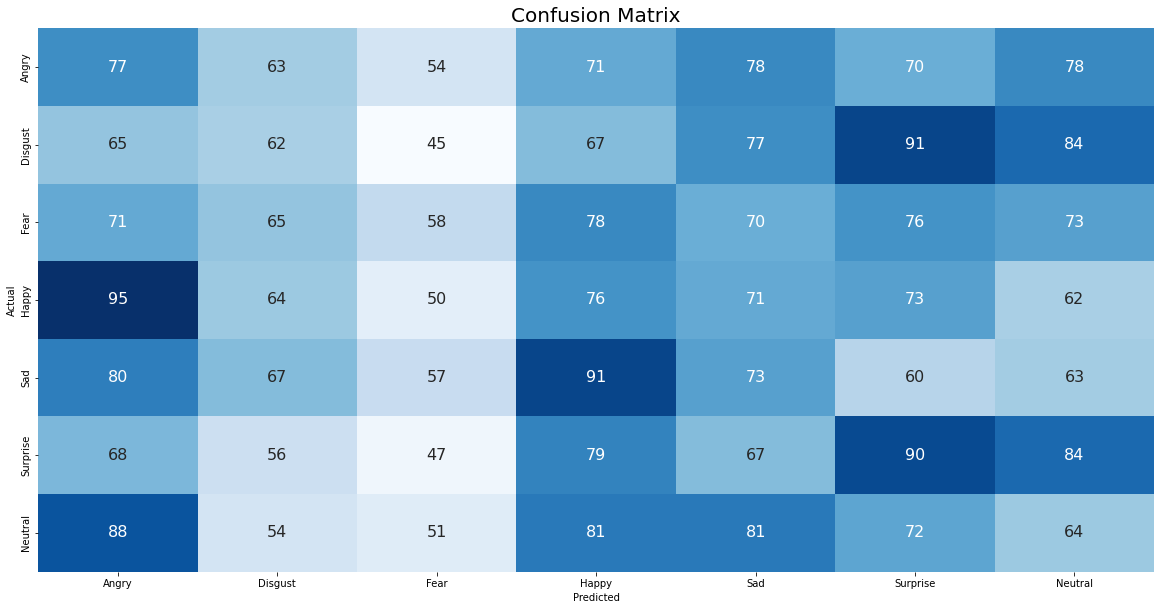

In [53]:
cm = pd.DataFrame(cm_data, columns=emotions, index = emotions)
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'
plt.figure(figsize = (20,10))
plt.title('Confusion Matrix', fontsize = 20)
sns.set(font_scale=1.2)
ax = sns.heatmap(cm, cbar=False, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='g')

In [100]:
from sklearn.metrics import classification_report
model_insight_acc = classification_report(y_labels, y_pre,output_dict=True)
model_insight_acc

{'0': {'precision': 0.14154411764705882,
  'recall': 0.15682281059063136,
  'f1-score': 0.14879227053140098,
  'support': 491},
 '1': {'precision': 0.14385150812064965,
  'recall': 0.12627291242362526,
  'f1-score': 0.13449023861171366,
  'support': 491},
 '2': {'precision': 0.16022099447513813,
  'recall': 0.11812627291242363,
  'f1-score': 0.13599062133645956,
  'support': 491},
 '3': {'precision': 0.13996316758747698,
  'recall': 0.15478615071283094,
  'f1-score': 0.14700193423597677,
  'support': 491},
 '4': {'precision': 0.14119922630560927,
  'recall': 0.14867617107942974,
  'f1-score': 0.14484126984126985,
  'support': 491},
 '5': {'precision': 0.16917293233082706,
  'recall': 0.18329938900203666,
  'f1-score': 0.1759530791788856,
  'support': 491},
 '6': {'precision': 0.12598425196850394,
  'recall': 0.13034623217922606,
  'f1-score': 0.12812812812812815,
  'support': 491},
 'accuracy': 0.14547570555717196,
 'macro avg': {'precision': 0.14599088549075198,
  'recall': 0.14547570

In [120]:
df_acc_model_1 = pd.DataFrame(model_insight_acc)
df_acc_model_1

,0,1,2,3,4,5,6,accuracy,macro avg,weighted avg
precision,0.141544,0.143852,0.160221,0.139963,0.141199,0.169173,0.125984,0.145476,0.145991,0.145991
recall,0.156823,0.126273,0.118126,0.154786,0.148676,0.183299,0.130346,0.145476,0.145476,0.145476
f1-score,0.148792,0.134490,0.135991,0.147002,0.144841,0.175953,0.128128,0.145476,0.145028,0.145028
support,491.000000,491.000000,491.000000,491.000000,491.000000,491.000000,491.000000,0.145476,3437.000000,3437.000000


In [85]:
df_acc_model_1.to_csv("model_matrix.csv")

In [135]:
df_acc_model_1 = df_acc_model_1[['0','1','2','3','4','5','6']]
df_acc_model_1

,0,1,2,3,4,5,6
precision,0.141544,0.143852,0.160221,0.139963,0.141199,0.169173,0.125984
recall,0.156823,0.126273,0.118126,0.154786,0.148676,0.183299,0.130346
f1-score,0.148792,0.134490,0.135991,0.147002,0.144841,0.175953,0.128128
support,491.000000,491.000000,491.000000,491.000000,491.000000,491.000000,491.000000


In [136]:
df_acc_model_1["matrix"] = df_acc_model_1.index

<ipython-input-136-c7705da47378>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [137]:
df_acc_model_1.index = [i for i in range(0,4)]

In [138]:
df_acc_model_1

,0,1,2,3,4,5,6,matrix
0,0.141544,0.143852,0.160221,0.139963,0.141199,0.169173,0.125984,precision
1,0.156823,0.126273,0.118126,0.154786,0.148676,0.183299,0.130346,recall
2,0.148792,0.134490,0.135991,0.147002,0.144841,0.175953,0.128128,f1-score
3,491.000000,491.000000,491.000000,491.000000,491.000000,491.000000,491.000000,support


In [140]:

fig_ = px.bar(df_acc_model_1.loc[df_acc_model_1["matrix"] != "support"],y=["0","1","2","3","4","5","6"],x="matrix",barmode="group",width=800,height=350,title="The matrix of all the classes")
fig_

In [86]:
# Upload experiment results to TensorBoard (uncomment to run)
!tensorboard dev upload --logdir ./log_dir \
   --name "The performance of the model before and after fin tuning" \
   --description "Training results for fine-tuning and feature extraction" \
   --one_shot

2023-03-12 20:23:45.857044: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib/python3.9/dist-packages/cv2/../../lib64:/usr/lib64-nvidia
2023-03-12 20:23:45.857148: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib/python3.9/dist-packages/cv2/../../lib64:/usr/lib64-nvidia
2023-03-12 20:23:45.857174: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.

***** TensorBoard Uploader *****

This will upload your 